## 供应链物流可视化2.0 - 数据处理与可视化测试

### Step 1 数据读取与预处理

#### Step 1.1 销售数据与地理信息矢量数据

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 读取销售数据
sales_data = pd.read_csv("101172909销售_20230927.csv")
sales_data["WORK_DATE"] = pd.to_datetime(sales_data["WORK_DATE"])

# 读取中国地级数据，来源网站：https://www.cnopendata.com/data/m/recent/chinese-administrative-divisions-shp.html
path = r"D:\JupyterNotebookFile\CMA\SC\中国行政区划shp数据\中国行政区划shp数据-2023年2月12日版\2023年\2023年地级"
cities = gpd.read_file(path + "/地级.shp")

In [3]:
# 检查两个数据表中哪些地名对不上
record = []
for i in sales_data["City"]:
    if pd.notnull(i):
        if len(cities.loc[cities["地名"].str.contains(i),"地名"].to_list()) == 0:
            if i not in record:
                record.append(i)

print(record)

['思茅地区', '西昌', '博乐', '格尔木市', '都匀市', '延吉', '个旧', '伊宁市', '库尔勒', '奎屯', '襄樊', '锡林浩特', '开远']


In [3]:
# 构造字典，将销售表中对不上的数据进行替换
city_dict = {
    "思茅地区" : "普洱市",
    "西昌" : "凉山彝族自治州",
    "博乐" : "博尔塔拉蒙古自治州",
    "格尔木市" : "海西蒙古族藏族自治州",
    "都匀市" : "黔南布依族苗族自治州",
    "延吉" : "延边朝鲜族自治州",
    "个旧" : "红河哈尼族彝族自治州",
    "伊宁市" : "伊犁哈萨克自治州",
    "库尔勒" : "巴音郭楞蒙古自治州",
    "奎屯" : "伊犁哈萨克自治州",
    "襄樊" : "襄阳市",
    "锡林浩特" : "锡林郭勒盟",
    "开远" : "红河哈尼族彝族自治州"
}

In [4]:
# 替换城市名称
def city_rename(x):
    if pd.notnull(x):
        if x in city_dict.keys():
            return city_dict[x]
        else:
            return cities.loc[cities["地名"].str.contains(x),"地名"].to_list()[0]
    else:
        return x

sales_data["地名"] = sales_data["City"].apply(city_rename)

In [5]:
# 按city聚类求和
# 注意：除非特殊设置，否则groupby会把有空值的索引自动去除，这就是为什么sales_data中有空值，但是聚合后的city_sales没有
city_sales = sales_data.groupby(["地名","WORK_DATE"], as_index=False).agg({
    'SLS_QTY' : 'sum',
    'SLS_AMT' : 'sum'
})
city_sales["MONTH"] = city_sales["WORK_DATE"].dt.strftime('%Y-%m')
city_sales["YEAR"] =  city_sales["WORK_DATE"].dt.strftime('%Y')
city_sales

,地名,WORK_DATE,SLS_QTY,SLS_AMT,MONTH,YEAR
0,七台河市,2023-05-29,1,87.61,2023-05,2023
1,七台河市,2023-05-31,1,87.61,2023-05,2023
2,七台河市,2023-06-03,1,87.61,2023-06,2023
3,七台河市,2023-06-08,1,87.61,2023-06,2023
4,七台河市,2023-06-11,2,175.22,2023-06,2023
...,...,...,...,...,...,...
10909,龙岩市,2023-07-03,1,176.10,2023-07,2023
10910,龙岩市,2023-07-04,1,119.50,2023-07,2023
10911,龙岩市,2023-07-13,3,352.21,2023-07,2023
10912,龙岩市,2023-07-22,3,352.21,2023-07,2023


#### Step 1.2 店铺经纬度数据获取

In [6]:
# 一段爬虫，获取经纬度
import requests
import re

wrong_list = []

def query(addr):
    #查询addr的经纬度
    template = 'https://apis.map.qq.com/jsapi?qt=geoc&addr={addr}&key=UGMBZ-CINWR-DDRW5-W52AK-D3ENK-ZEBRC&output=jsonp&pf=jsapi&ref=jsapi&cb=qq.maps._svcb2.geocoder0'
    url = template.format(addr=addr)
    resp = requests.get(url)
    # 便于店铺地址不清晰时，进行寻找替换
    try:
        x = re.findall('pointx":"(.*?)",',resp.text)[0]
        y = re.findall('pointy":"(.*?)",',resp.text)[0]
        return x,y
    except:
        wrong_list.append(addr)
        return (0,0)

# stores = sales_data["LOC_IDNT"].drop_duplicates()
# store_list = pd.read_excel("Store List-全国.xlsx")
# stores = pd.merge(stores, store_list[['Store', '店铺地址']], left_on="LOC_IDNT", right_on="Store", how='inner')
# stores["经纬度"] = stores["店铺地址"].apply(query)
# stores.to_excel("stores_loc.xlsx", index=False)

In [7]:
# 读取店铺经纬度信息
store_pog = pd.read_excel("stores_pog.xlsx")
# store_loc["longitude"] = store_loc["经纬度"].apply(lambda x: float(eval(x)[0]))
# store_loc["latitude"] = store_loc["经纬度"].apply(lambda x: float(eval(x)[1]))
# 省略从store_list匹配省市区信息，匹配后还进行了与cities数据表中省市区数据的对齐，方法与sales_data中对地名的处理一致

### Step 2 结合地理信息的数据可视化

#### Step 2.1 销售数据可视化

In [8]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' # 设置字体为微软雅黑 # 中文字体情况
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

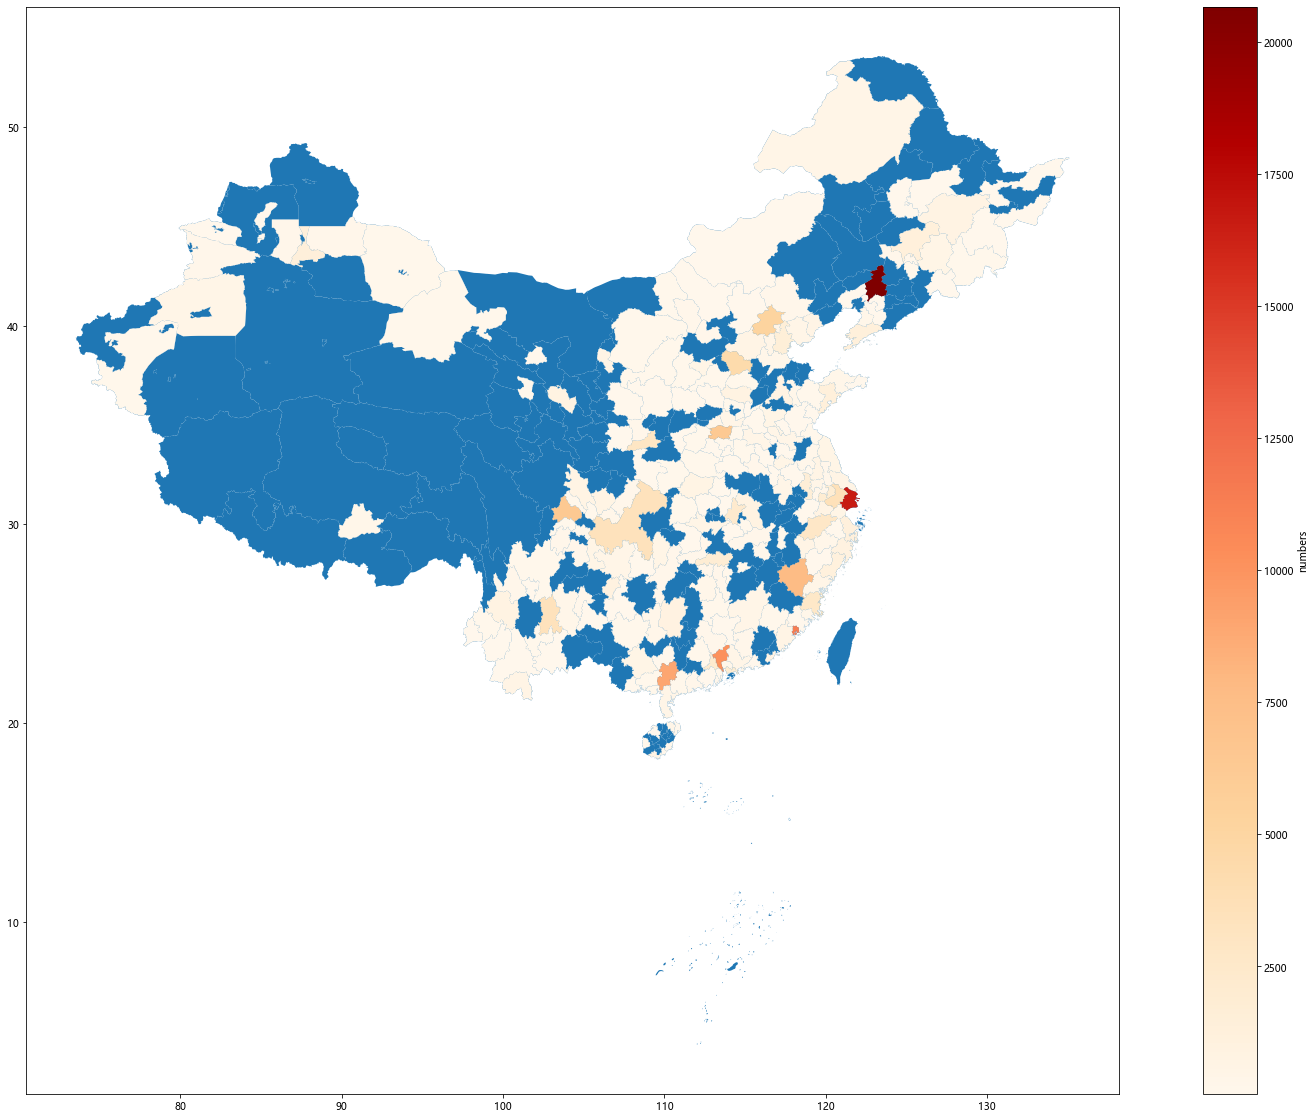

In [9]:
# 将销售数据与地理数据合并
# 一个疑问是无法使用pd.merge或者join，二者都会报错
data_merge = cities[["地名","省级","geometry"]].merge(city_sales, on="地名")

# 设置时间序列数据为索引
data_merge.set_index("WORK_DATE", inplace = True)

# 运行以下代码中，出现过一个警告，内容主要如下：
# The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
# 解决方法是顺着提示找到出问题的库，是 geopandas中的plooting.py，打开该py，根据提示找到出问题那一行，将 'type' 改成 'geom_type'。

fig, ax = plt.subplots(figsize=(30, 20))

cities.plot(ax=ax) # 要先画出地图边界
data_merge.loc["2023-06-01"].plot(
    ax=ax,
    column='SLS_AMT',
    legend=True, 
    cmap='OrRd',
    legend_kwds={'label': "numbers"}
)

plt.show()

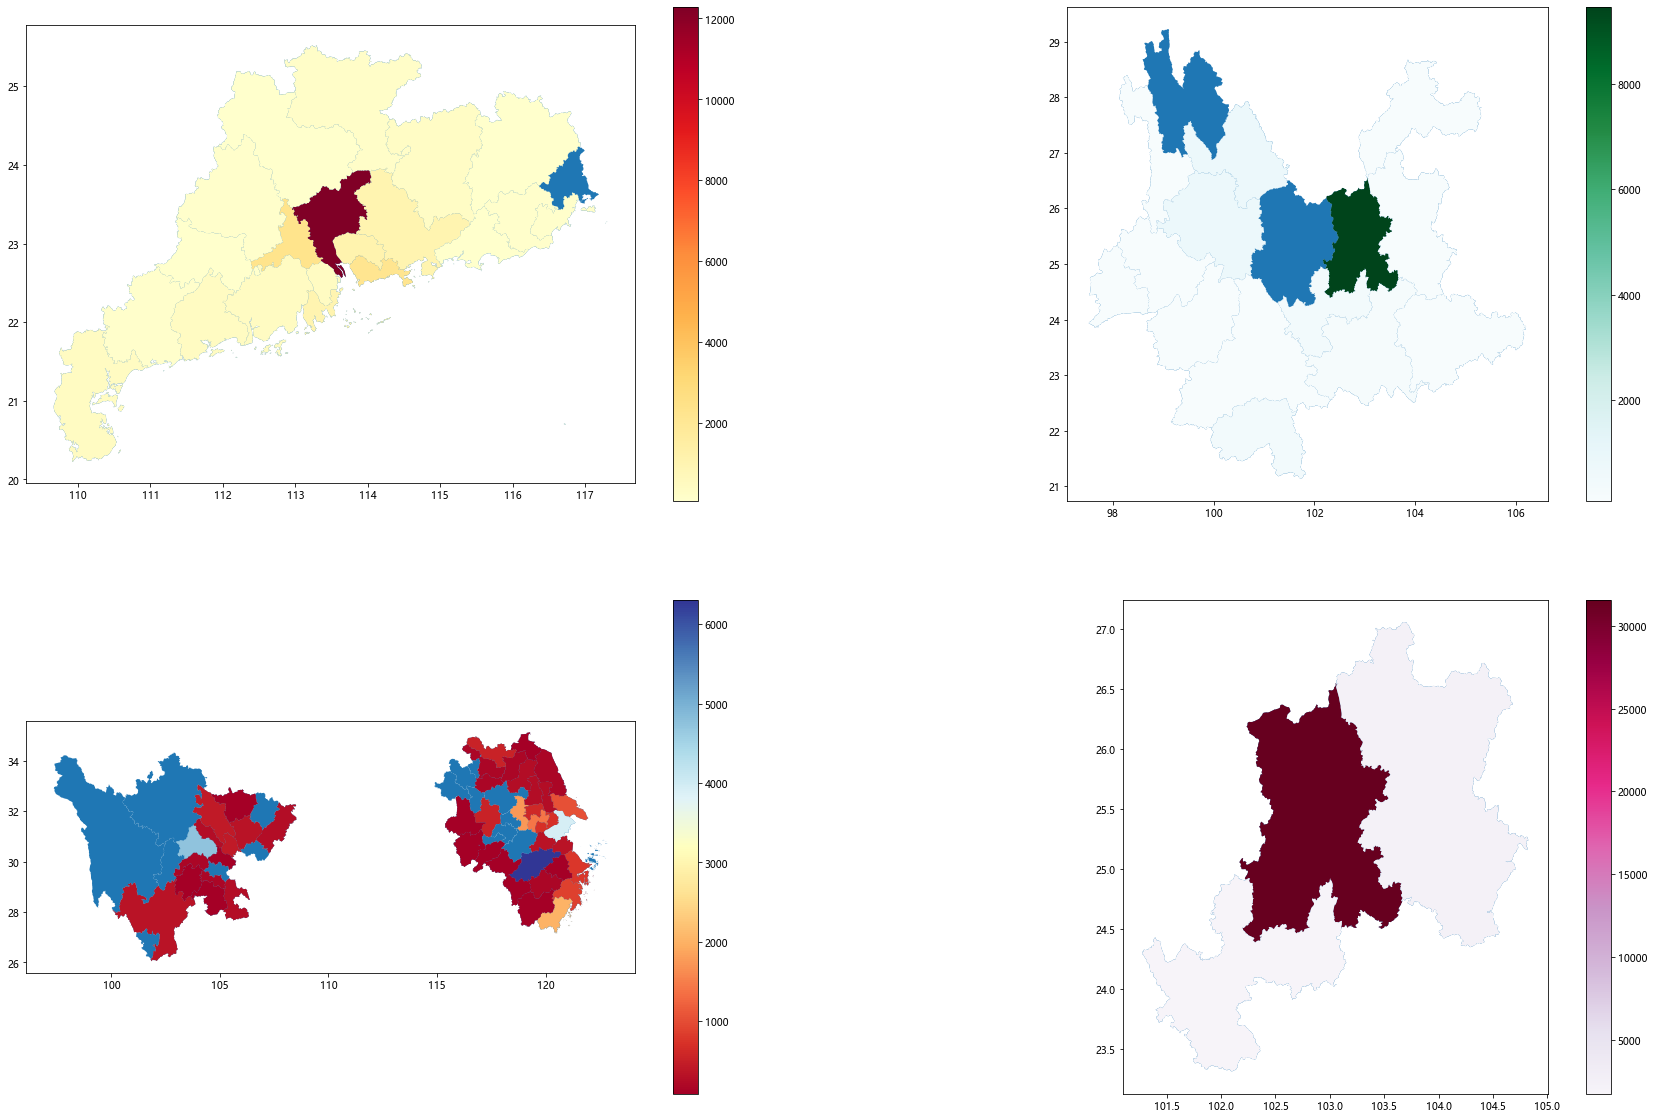

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(30, 20))

# 筛选出一个省
cities.loc[cities["省级"]=="广东省"].plot(ax=axes[0, 0])
data_merge.loc[(data_merge.index=="2023-05-26")&(data_merge["省级"]=="广东省"),:].plot(
    ax=axes[0, 0],
    column='SLS_AMT',
    legend=True, 
    cmap='YlOrRd'
)


cities.loc[cities["省级"]=="云南省"].plot(ax=axes[0, 1])
data_merge.loc[(data_merge.index=="2023-05-26")&(data_merge["省级"]=="云南省"),:].plot(
    ax=axes[0, 1],
    column='SLS_AMT',
    legend=True, 
    cmap='BuGn'
)

# 满足多个筛选条件的情况，建议用isin，可以传入一个列表；
cities.loc[cities["省级"].isin(["江苏省", "浙江省","安徽省","四川省"])].plot(ax=axes[1, 0])
data_merge.loc[(data_merge["省级"].isin(["江苏省", "浙江省","安徽省","四川省"])) & 
               (data_merge.index == "2023-06-21"),:].plot(
    ax=axes[1, 0],
    column='SLS_AMT',
    legend=True, 
    cmap='RdYlBu'
)

# 时间序列数据的聚合
# 先对city_sales进行城市筛选，再按月份聚合，筛选月份后，匹配geometry，最后绘图
cities.loc[cities["地名"].isin(["昆明市", "曲靖市", "玉溪市"])].plot(ax=axes[1, 1])
df1 = city_sales.loc[city_sales["地名"].isin(["昆明市", "曲靖市", "玉溪市"])].groupby(["地名","MONTH"], as_index = False).agg({
    'SLS_QTY' : 'sum',
    'SLS_AMT' : 'sum'
})
df2 = cities[["地名","省级","geometry"]].merge(df1, on="地名")
df2.loc[df2["MONTH"] == '2023-05',:].plot(
    ax=axes[1, 1],
    column='SLS_AMT',
    legend=True, 
    cmap='PuRd'
)

# 

plt.show()

#### Step 2.2 增加仓库及店铺位置

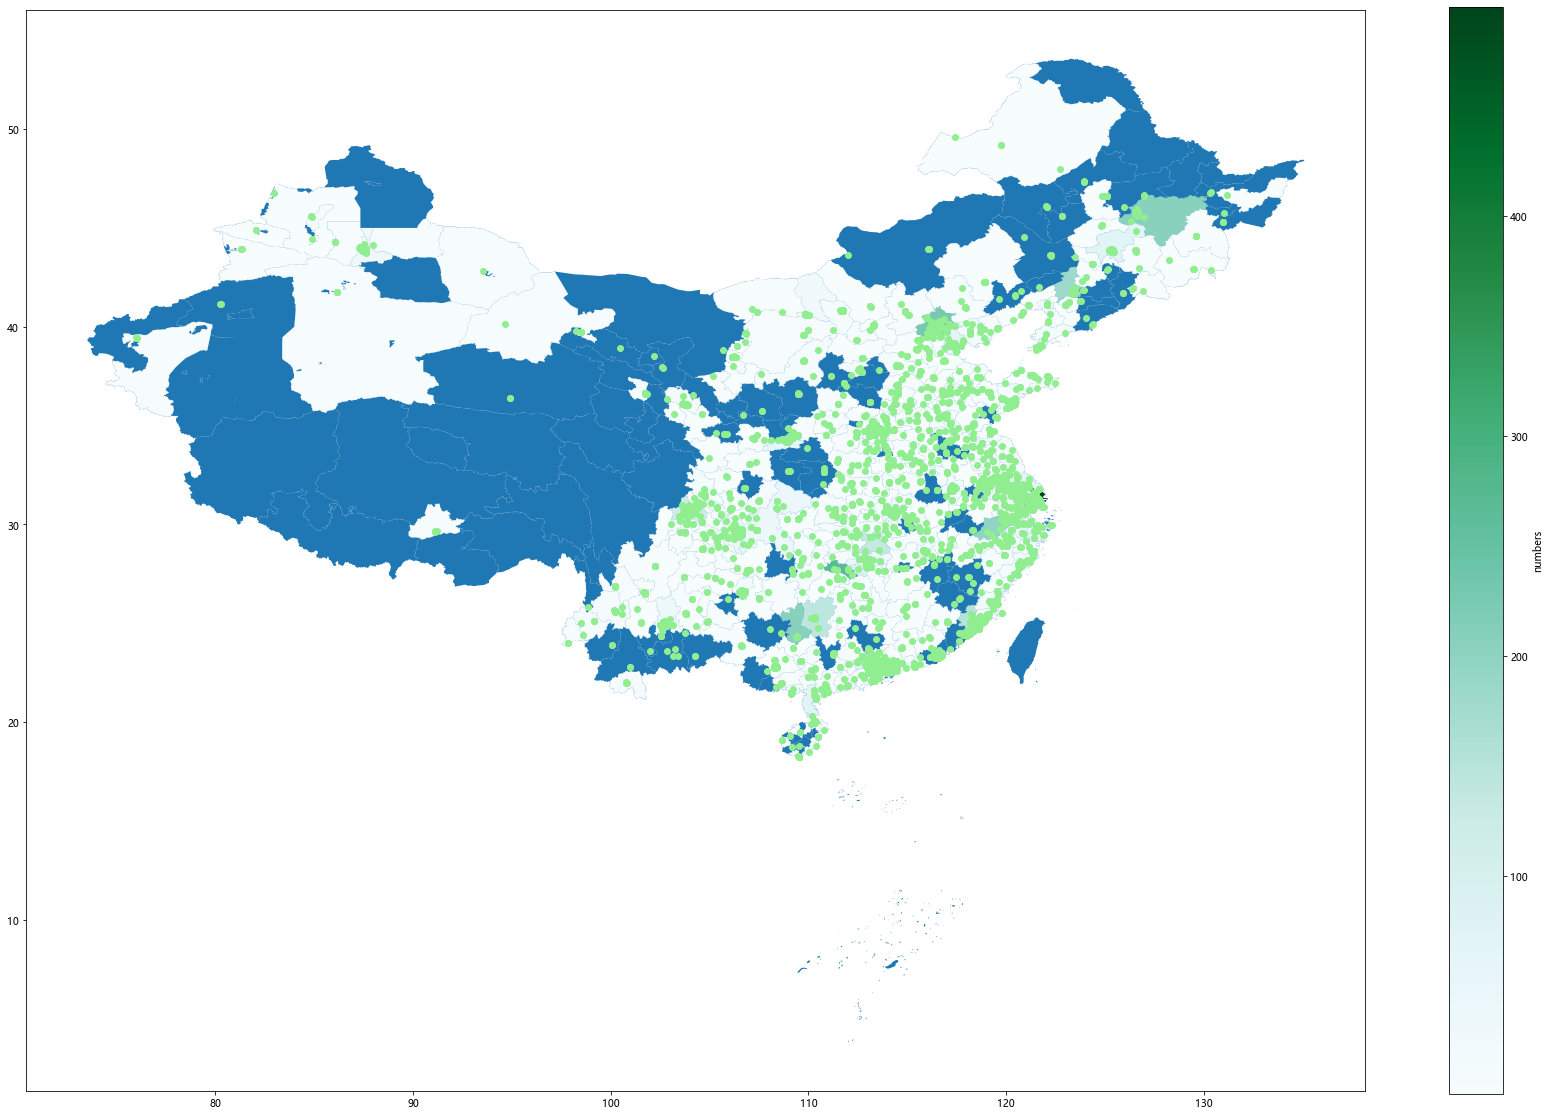

In [11]:
# 使用geopandas，根据店铺经纬度在地图上绘制散点
store_plot = gpd.GeoDataFrame(store_pog, geometry=gpd.points_from_xy(store_pog.longitude, store_pog.latitude))

fig, ax = plt.subplots(figsize=(30, 20))
cities.plot(ax=ax) # 要先画出地图边界
data_merge.loc["2023-06-05"].plot(
    ax=ax,
    column='SLS_QTY',
    legend=True, 
    cmap='BuGn',
    legend_kwds={'label': "numbers"}
)
store_plot.plot(ax=ax, color='lightgreen')

plt.show()

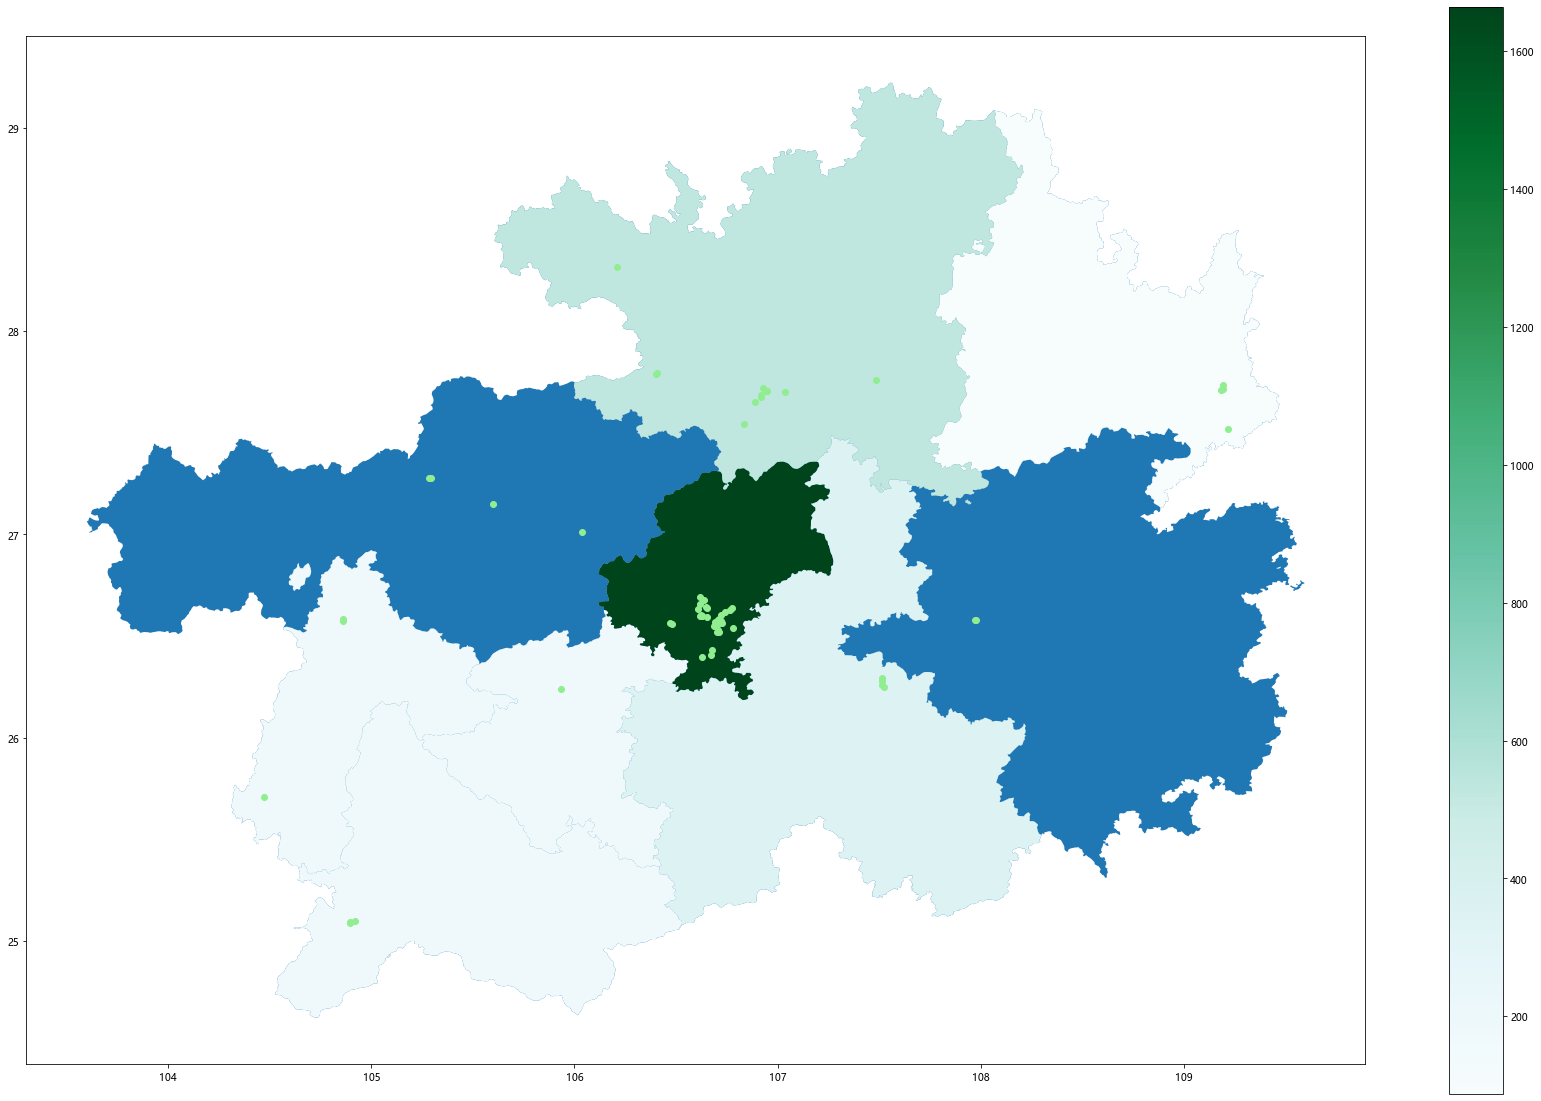

In [12]:
fig, ax = plt.subplots(figsize=(30, 20))
cities.loc[cities["省级"]=="贵州省"].plot(ax=ax)
data_merge.loc[(data_merge.index=="2023-06-10")&(data_merge["省级"]=="贵州省"),:].plot(
    ax=ax,
    column='SLS_AMT',
    legend=True, 
    cmap='BuGn'
)
store_plot.loc[store_plot["省份"]=="贵州省"].plot(
    ax=ax, 
    color='lightgreen'
)
plt.show()

#### Step 2.3 结合仓存数据显示店铺与仓库

In [13]:
#读入并匹配某日的库存数据
daily_soh = pd.read_csv("Daily SOH-101172909.csv")
daily_soh["UPDATE_DATE"] = pd.to_datetime(daily_soh["UPDATE_DATE"])
daily_soh["TTL_in_transit"] = daily_soh["IN_TRANSIT_QTY"] + daily_soh["TSF_EXPECTED_QTY"] + daily_soh["TSF_EXPECTED_QTY2"]

store_soh = store_plot.merge(
    daily_soh.loc[
        daily_soh["UPDATE_DATE"]=="2024-01-15",
        ["LOC","IN_TRANSIT_QTY", "TSF_EXPECTED_QTY", "AVAILABLE_STOCK", "TSF_EXPECTED_QTY2"]
    ],
    left_on = "LOC_IDNT",
    right_on = "LOC",
    how = "left"
)
# 空值全部替换为0
store_soh[[
    "IN_TRANSIT_QTY", 
    "TSF_EXPECTED_QTY", 
    "AVAILABLE_STOCK", 
    "TSF_EXPECTED_QTY2"
]] = store_soh[[
    "IN_TRANSIT_QTY", 
    "TSF_EXPECTED_QTY", 
    "AVAILABLE_STOCK", 
    "TSF_EXPECTED_QTY2"
]].fillna(0)
# store_soh.to_excel("store_soh_test.xlsx",index=False)
# 为了提升美观效果，库存数据乘以15展示
store_soh["IN_TRANSIT_QTY_s"] = store_soh["IN_TRANSIT_QTY"]*15
store_soh["TSF_EXPECTED_QTY_s"] = store_soh["TSF_EXPECTED_QTY"]*15
store_soh["AVAILABLE_STOCK_s"] = store_soh["AVAILABLE_STOCK"]*15
store_soh["TSF_EXPECTED_QTY2_s"] = store_soh["TSF_EXPECTED_QTY2"]*15

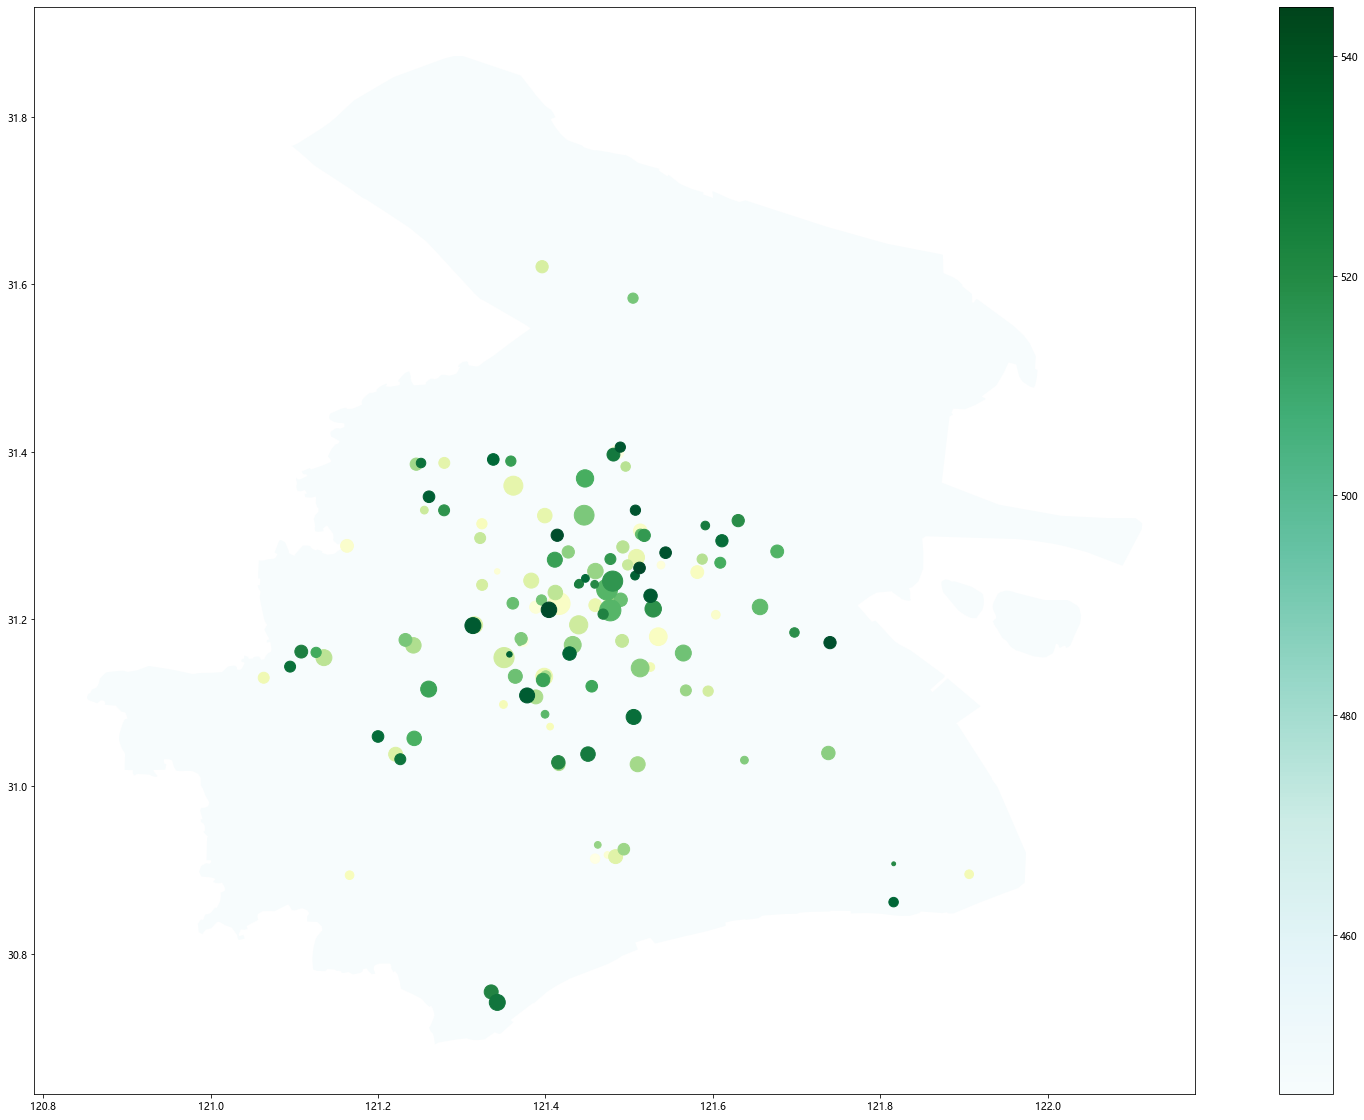

In [14]:
# 运用gpd.plot 中的markersize参数将散点半径与库存联系
fig, ax = plt.subplots(figsize=(30, 20))

data_merge.loc[(data_merge.index=="2023-06-05")&(data_merge["地名"]=="上海市"),:].plot(
    ax=ax,
    column='SLS_QTY',
    legend=True,
    cmap='BuGn'
)

# x = np.linspace(
#             min(store_soh.loc[store_soh["市区"]=="广州市","AVAILABLE_STOCK_s"]),
#             max(store_soh.loc[store_soh["市区"]=="广州市","AVAILABLE_STOCK_s"]),
#             len(store_soh.loc[store_soh["市区"]=="广州市","LOC_IDNT"].drop_duplicates())
#         )

store_soh.loc[store_soh["市区"]=="上海市"].plot(
    ax=ax,
    marker = 'o',
    markersize = 'AVAILABLE_STOCK_s',
    # 配色方案
#     color = plt.get_cmap('Blues')(
#         (x-np.min(x))/(np.max(x)-np.min(x))
#     )
    cmap = 'YlGn'
)

plt.show()

# 颜色未能依据大小渐变

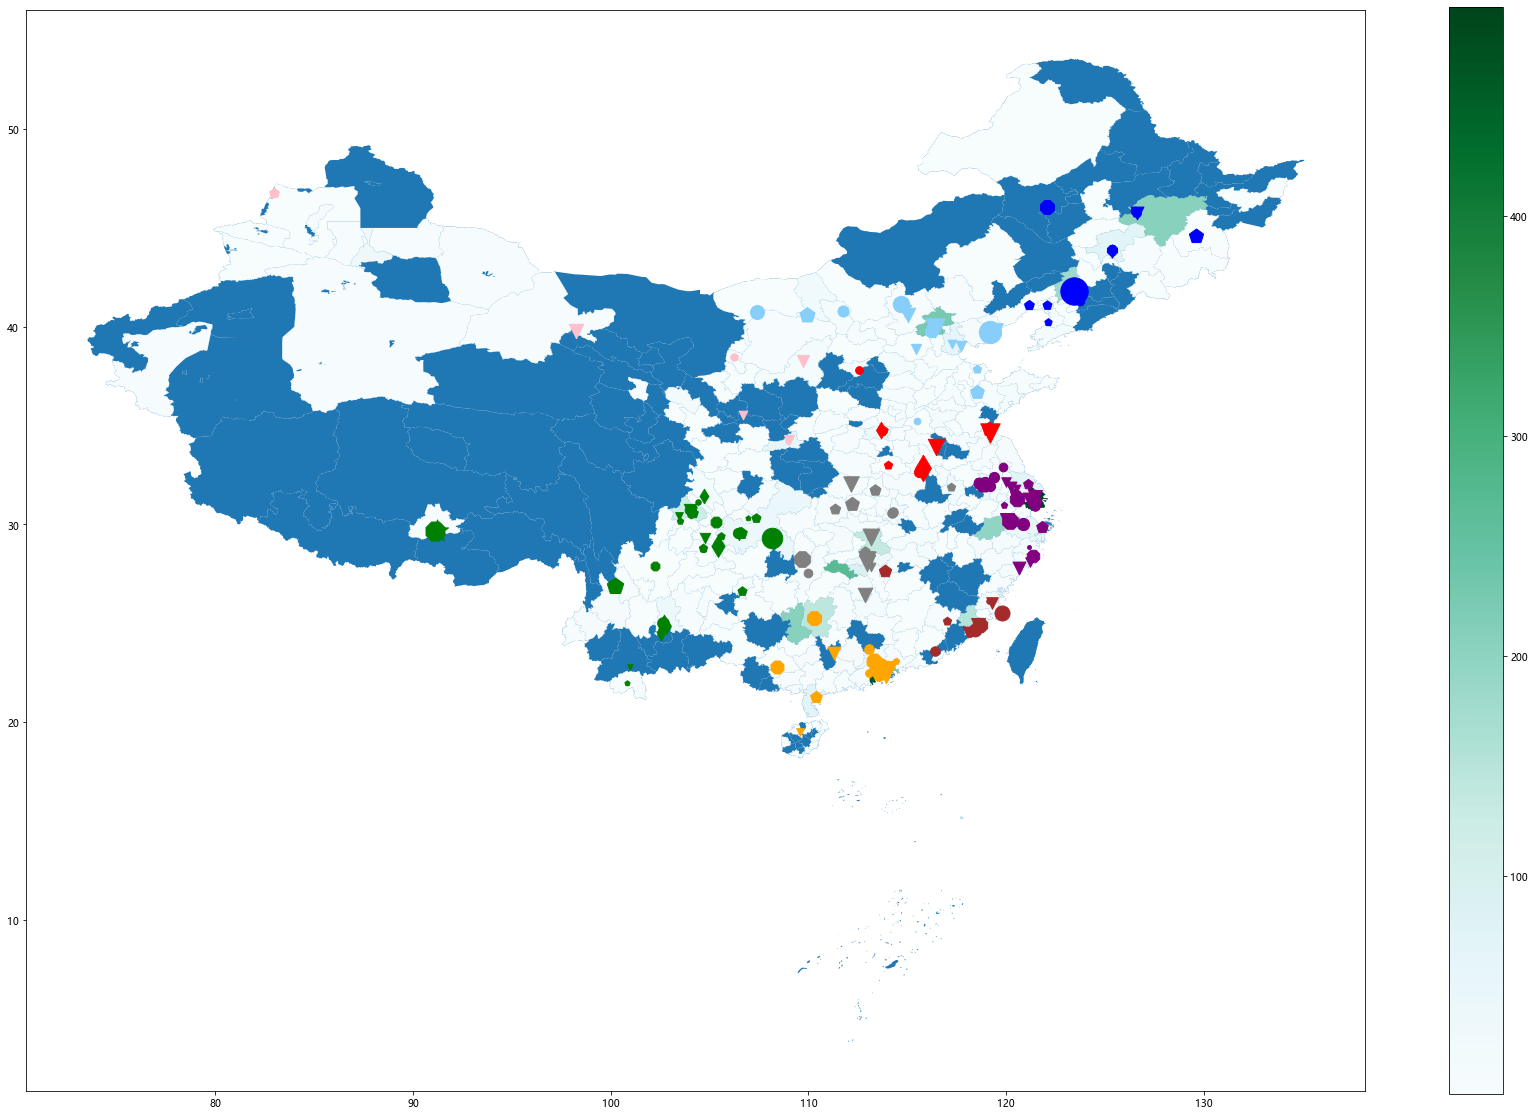

In [35]:
# Target：按照颜色区分所属的仓库，按照形状区分店铺类别
# Method：面向对象的编程，将每个店铺/仓库创建为一个对象
# Problem：在绘制全国3000多家店铺时，该方法速度太慢

import store
from shapely import geometry

dc_color = {
    991: 'blue',
    992: 'purple',
    996: 'grey',
    997: 'green',
    998: 'orange',
    9901: 'red',
    9902: 'brown',
    9903: 'lightskyblue',
    9907: 'pink'
}

type_shape = {
    'Embryo': 'o',
    'Basic': 'v',
    'Baby': 'p',
    'Anchor': '8',
    'Star': 'd',
    'Super Star': '*'
}

store_list = dict()

def soh_update(update_date):
    to_date = pd.to_datetime(update_date)
    data = daily_soh.loc[daily_soh["UPDATE_DATE"]==to_date,:]
    for s in data["LOC"].drop_duplicates():
        try:
            store_list[s].soh_ch(data.loc[data["LOC"]==s,"AVAILABLE_STOCK"].values[0])
        except:
            pass


for s in store_soh["LOC_IDNT"].drop_duplicates():
    store_list[s] = store.Store(
        longitude = store_soh.loc[store_soh["LOC_IDNT"]==s,"longitude"].values[0],
        latitude = store_soh.loc[store_soh["LOC_IDNT"]==s,"latitude"].values[0],
        rank = store_soh.loc[store_soh["LOC_IDNT"]==s,"Type"].values[0],
        dc = store_soh.loc[store_soh["LOC_IDNT"]==s,"DC"].values[0],
        store_id = store_soh.loc[store_soh["LOC_IDNT"]==s,"LOC_IDNT"].values[0]
    )
    
for s in store_list:
    store_list[s].color_ch(dc_color[store_list[s].dc])
    store_list[s].marker_ch(type_shape[store_list[s].rank])
    
soh_update("2024-01-15")


# 绘图
fig, ax = plt.subplots(figsize=(30, 20))
cities.plot(ax=ax) # 要先画出地图边界

data_merge.loc["2023-06-05"].plot(
    ax=ax,
    column='SLS_QTY',
    legend=True,
    cmap='BuGn'
)

c = 0
for s in store_list:
    point = gpd.GeoSeries( 
        [geometry.Point(store_list[s].longitude, store_list[s].latitude)]
    )
    point.plot(
        ax = ax,
        marker = store_list[s].marker,
        markersize = store_list[s].soh * 15,
        color = store_list[s].color
    )
    c+=1
    if c >=200:
        break


plt.show()

# 最好对某几个城市进行可视化，提高美观度

### Step 3 制作图形交互界面

In [12]:
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg